# Instructions

- Unzip `data.zip` containing:
  - Raw data from [Hugging Face](https://huggingface.co/datasets/dair-ai/emotion)
  - Processed CSV files for immediate use

- Requirements: Python 3.6+, TensorFlow, pandas, numpy, matplotlib, seaborn, scikit-learn

- Running the notebook:
  - Execute all cells sequentially
  - Final cell trains all models and displays results
  - Performance metrics will be saved to `results.csv`

- Models compared: SimpleRNN (baseline), BiGRU, and BiLSTM for emotion classification


In [14]:
import os, random, json, pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

# reproducibility
SEED = 35
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


### Utility plotting helpers

In [15]:
def plot_history(history, title="Training Curves"):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

def evaluate_and_plot(model, x_test, y_test, label_names):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=label_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_names,
        yticklabels=label_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    p, r, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro", zero_division=0
    )
    acc = (y_pred == y_test).mean()
    return dict(accuracy=acc, precision=p, recall=r, f1=f1)


### Data loader / tokenizer

In [ ]:
LABEL_MAP = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
}

def load_and_prepare_data(
    processed_dir="/data/processed",
    max_vocab=10_000,
    max_len=50,
):
    def _csv(name):
        return pd.read_csv(pathlib.Path(processed_dir) / f"emotion_{name}.csv")

    train_df, val_df, test_df = map(_csv, ["train", "val", "test"])

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=max_vocab, oov_token="<OOV>"
    )
    tokenizer.fit_on_texts(train_df["text"])

    def _encode(series):
        seqs = tokenizer.texts_to_sequences(series)
        return tf.keras.preprocessing.sequence.pad_sequences(
            seqs, maxlen=max_len, padding="post", truncating="post"
        )

    x_train, x_val, x_test = map(_encode, [train_df["text"], val_df["text"], test_df["text"]])
    y_train, y_val, y_test = train_df["label"].values, val_df["label"].values, test_df["label"].values

    return (
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        tokenizer,
        len(LABEL_MAP),
        list(LABEL_MAP.values()),
    )

data = load_and_prepare_data()  # run once; returns a tuple we’ll unpack later


### Model builders (RNN / GRU / LSTM)


In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Bidirectional

def build_rnn_model(vocab_size, max_len, num_classes):
    return Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ])

def build_gru_model(vocab_size, max_len, num_classes):
    return Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        Bidirectional(GRU(64)),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ])

def build_lstm_model(vocab_size, max_len, num_classes):
    return Sequential([
        Embedding(vocab_size, 64, input_length=max_len),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ])


### Compile-&-train helper

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def compile_and_train(
    model,
    x_train,
    y_train,
    x_val,
    y_val,
    epochs=15,
    lr=1e-3,
    batch_size=32,
    patience=3,
):
    model.compile(
        optimizer=Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    es = EarlyStopping(patience=patience, restore_best_weights=True)
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=2,
    )
    plot_history(history, model.name or "model")
    return model


### Train & compare all models


🟢  Training SimpleRNN
Epoch 1/15


/Users/ansari/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 - 5s - 9ms/step - accuracy: 0.3247 - loss: 1.5898 - val_accuracy: 0.3520 - val_loss: 1.5812
Epoch 2/15
500/500 - 3s - 7ms/step - accuracy: 0.3354 - loss: 1.5828 - val_accuracy: 0.3520 - val_loss: 1.5836
Epoch 3/15
500/500 - 3s - 7ms/step - accuracy: 0.3354 - loss: 1.5694 - val_accuracy: 0.3510 - val_loss: 1.5626
Epoch 4/15
500/500 - 3s - 7ms/step - accuracy: 0.3468 - loss: 1.5400 - val_accuracy: 0.3695 - val_loss: 1.5462
Epoch 5/15
500/500 - 3s - 7ms/step - accuracy: 0.3711 - loss: 1.4695 - val_accuracy: 0.3490 - val_loss: 1.5807
Epoch 6/15
500/500 - 3s - 7ms/step - accuracy: 0.4033 - loss: 1.3906 - val_accuracy: 0.4135 - val_loss: 1.3832
Epoch 7/15
500/500 - 3s - 7ms/step - accuracy: 0.4528 - loss: 1.2766 - val_accuracy: 0.4360 - val_loss: 1.3241
Epoch 8/15
500/500 - 3s - 7ms/step - accuracy: 0.4242 - loss: 1.2712 - val_accuracy: 0.4180 - val_loss: 1.3080
Epoch 9/15
500/500 - 3s - 7ms/step - accuracy: 0.4857 - loss: 1.1656 - val_accuracy: 0.4395 - val_loss: 1.2969
Epoch 10/15


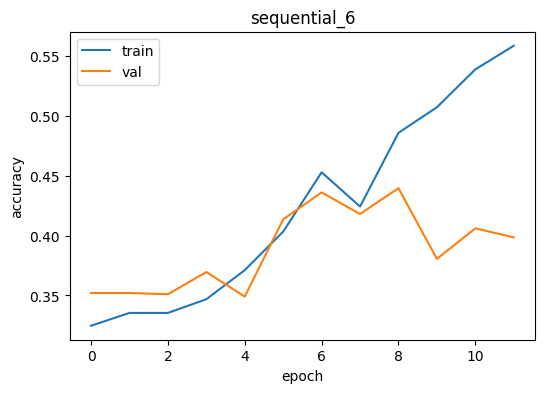

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

     sadness       0.37      0.20      0.26       581
         joy       0.46      0.77      0.58       695
        love       0.00      0.00      0.00       159
       anger       0.42      0.76      0.54       275
        fear       0.28      0.05      0.09       224
    surprise       0.00      0.00      0.00        66

    accuracy                           0.43      2000
   macro avg       0.26      0.30      0.24      2000
weighted avg       0.36      0.43      0.36      2000



/Users/ansari/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ansari/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ansari/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

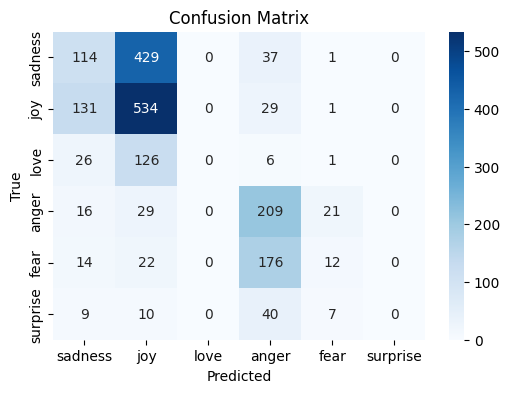


🟢  Training BiGRU
Epoch 1/15


/Users/ansari/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 - 13s - 26ms/step - accuracy: 0.5811 - loss: 1.1121 - val_accuracy: 0.7750 - val_loss: 0.6405
Epoch 2/15
500/500 - 11s - 22ms/step - accuracy: 0.8516 - loss: 0.4270 - val_accuracy: 0.8665 - val_loss: 0.4016
Epoch 3/15
500/500 - 11s - 23ms/step - accuracy: 0.9125 - loss: 0.2570 - val_accuracy: 0.8860 - val_loss: 0.3374
Epoch 4/15
500/500 - 11s - 22ms/step - accuracy: 0.9406 - loss: 0.1778 - val_accuracy: 0.8870 - val_loss: 0.3491
Epoch 5/15
500/500 - 11s - 22ms/step - accuracy: 0.9554 - loss: 0.1310 - val_accuracy: 0.8910 - val_loss: 0.3484
Epoch 6/15
500/500 - 11s - 23ms/step - accuracy: 0.9660 - loss: 0.0992 - val_accuracy: 0.8980 - val_loss: 0.3731


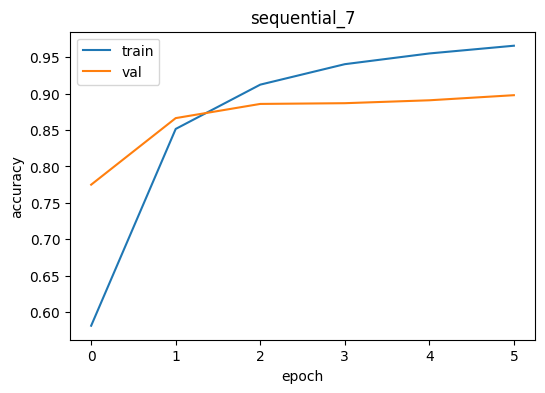

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

     sadness       0.93      0.96      0.94       581
         joy       0.95      0.91      0.93       695
        love       0.62      0.64      0.63       159
       anger       0.87      0.89      0.88       275
        fear       0.87      0.86      0.87       224
    surprise       0.65      0.70      0.67        66

    accuracy                           0.89      2000
   macro avg       0.81      0.82      0.82      2000
weighted avg       0.89      0.89      0.89      2000



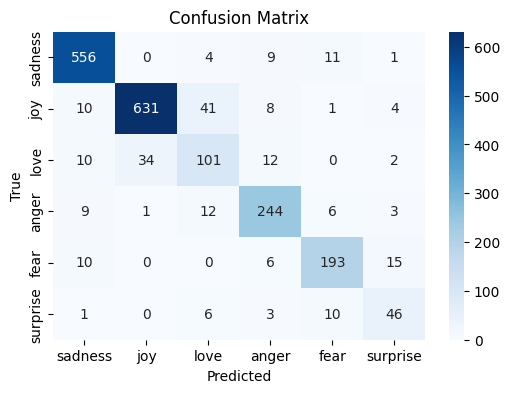


🟢  Training BiLSTM
Epoch 1/15


/Users/ansari/.pyenv/versions/3.11.6/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 - 12s - 24ms/step - accuracy: 0.5418 - loss: 1.1778 - val_accuracy: 0.7545 - val_loss: 0.6482
Epoch 2/15
500/500 - 11s - 22ms/step - accuracy: 0.8402 - loss: 0.4193 - val_accuracy: 0.8970 - val_loss: 0.3131
Epoch 3/15
500/500 - 11s - 23ms/step - accuracy: 0.9383 - loss: 0.1780 - val_accuracy: 0.9010 - val_loss: 0.3263
Epoch 4/15
500/500 - 11s - 22ms/step - accuracy: 0.9578 - loss: 0.1183 - val_accuracy: 0.9025 - val_loss: 0.3398
Epoch 5/15
500/500 - 11s - 22ms/step - accuracy: 0.9654 - loss: 0.1028 - val_accuracy: 0.9060 - val_loss: 0.3740


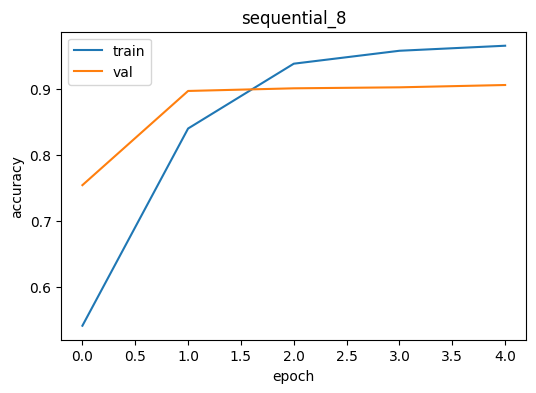

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

     sadness       0.94      0.95      0.94       581
         joy       0.90      0.95      0.93       695
        love       0.80      0.64      0.71       159
       anger       0.89      0.89      0.89       275
        fear       0.90      0.86      0.88       224
    surprise       0.69      0.62      0.66        66

    accuracy                           0.90      2000
   macro avg       0.85      0.82      0.84      2000
weighted avg       0.90      0.90      0.90      2000



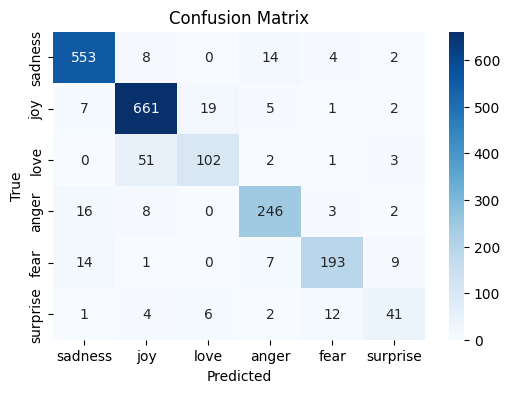

In [19]:
(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    tokenizer,
    num_classes,
    label_names,
) = data  # unpack once for readability

builders = {
    "SimpleRNN": build_rnn_model,
    "BiGRU": build_gru_model,
    "BiLSTM": build_lstm_model,
}

results = []

for name, builder in builders.items():
    print(f"\n🟢  Training {name}")
    model = builder(vocab_size=10_000, max_len=50, num_classes=num_classes)
    model._name = name  # for nicer plot titles

    model = compile_and_train(model, x_train, y_train, x_val, y_val)
    metrics = evaluate_and_plot(model, x_test, y_test, label_names)
    metrics["model"] = name
    results.append(metrics)

df_results = pd.DataFrame(results).round(4)
df_results

df_results.to_csv("results.csv", index=False)
